# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [227]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Let's generate our dataset and take a look on it.

In [249]:
def draw_colorful_points(points, labels):
    plt.scatter(points[:, 0], points[:, 1], c=labels)

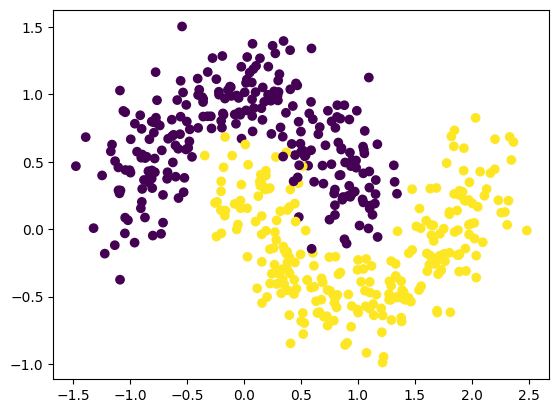

In [208]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
draw_colorful_points(moons_points, moons_labels)

In [209]:
def train_val_test_split(data, target, a=0.35, b=0.1):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=a)
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=b)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [87]:
moons_train, moons_val, moons_test, moons_label_train, moons_label_val, moons_label_test = \
    train_val_test_split(moons_points, moons_labels) 

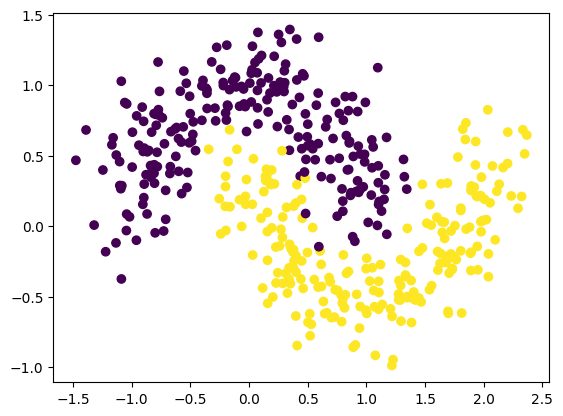

In [211]:
draw_colorful_points(moons_train, moons_label_train)

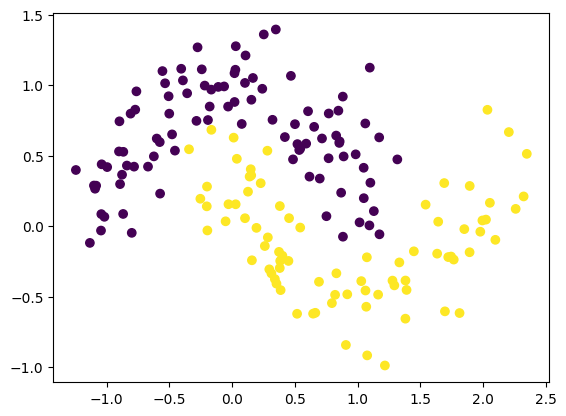

In [212]:
draw_colorful_points(moons_test, moons_label_test)

There is enough points, so shape is preserved in train data set.

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [262]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='saga', tol=1e-3, max_iter=1000, C=1, class_weight='balanced')
svm = SVC(kernel="linear", class_weight='balanced')


In [265]:
def show_decisions(clf, X, y, a=0.35, ax=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=a)
    clf.fit(X_train, y_train)
    plot_decision_regions(X, y, clf=clf, ax=ax)
    y_pred = clf.predict(X_test)
    plt.title(f'accuracy={accuracy_score(y_pred=y_pred, y_true=y_test)}')


def show_decisions_moons(clf, ax=None):
    show_decisions(clf, X=moons_points, y=moons_labels, ax=ax)

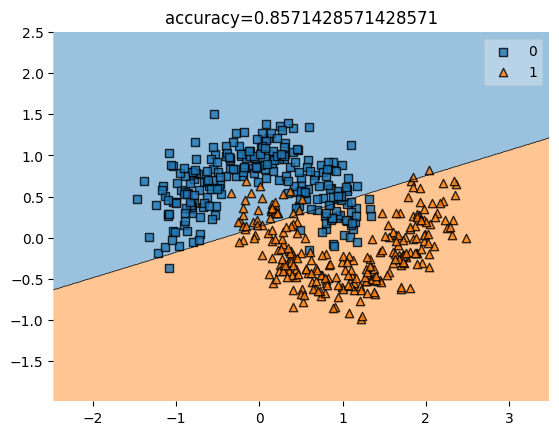

In [266]:
show_decisions_moons(lr)

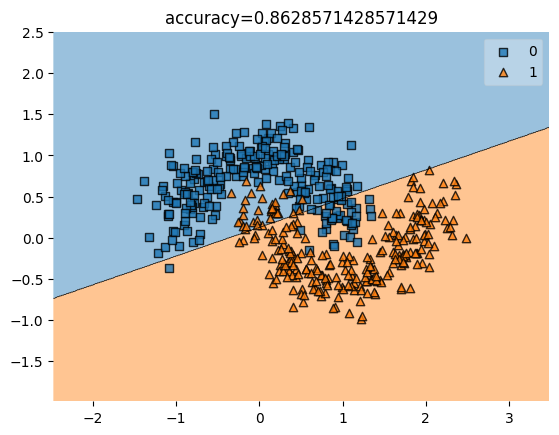

In [267]:
show_decisions_moons(svm)

Logistic Regression and linear SVM are almost the same. The line separates nicely the outer ends of moons, but, inevitably, makes many mistakes on inner ends

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

### poly

Let's try cubic polynomial right off the bat as the separating curve looks cubic to me

In [74]:
def mk_svm_poly(degree, C=1, class_weight='balanced'):
    return SVC(kernel="poly", class_weight=class_weight, degree=degree, C=C)
svm_cubic = mk_svm_poly(3)

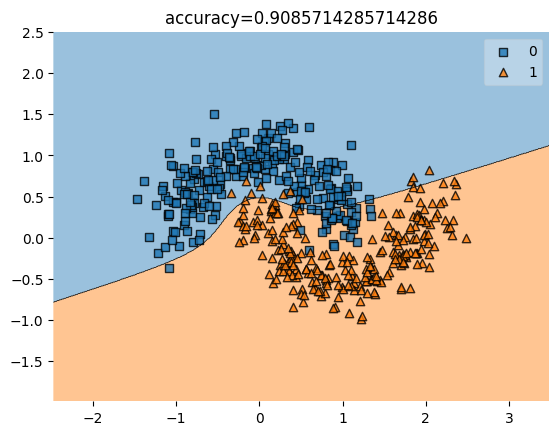

In [268]:
show_decisions_moons(svm_cubic)

Not bad! Let's see if weights can help. Since the classes are rather symmetric, we might hope that, fitting the first one nicely, we fit the second one nicely, too (given that the separating line is symmetric, too.) 

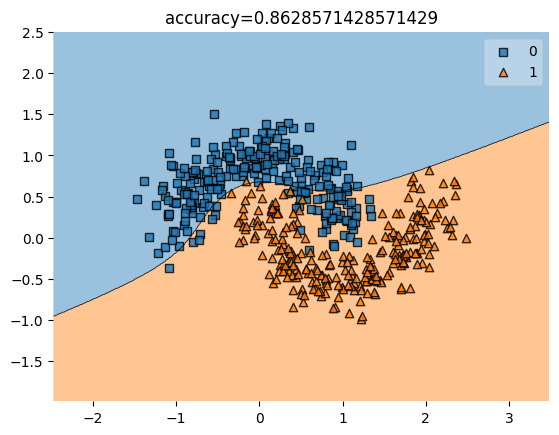

In [269]:
svm_cubic_w = mk_svm_poly(3, class_weight={0: 1, 1: 2})
show_decisions_moons(svm_cubic_w)

Weights fixed some false-1's but added false-0's. The symmetricity of the separation line did not live to up our hopes, and accuracy dropped

#### other degrees

In [270]:
def show_svm_poly_decisions(C=1, odds_only=True, start=1, end=11):
    #fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), sharey=True)
    # for some reason, subplotting takes A LOT of time. I blame mlxtend

    step = 2 if odds_only else 1
    for j in range(start, end, step):
        show_decisions_moons(mk_svm_poly(j, C=C))
        plt.suptitle(f"degree={j}")
        plt.show()

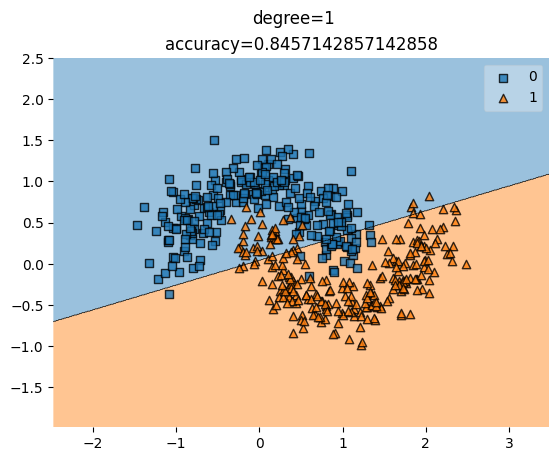

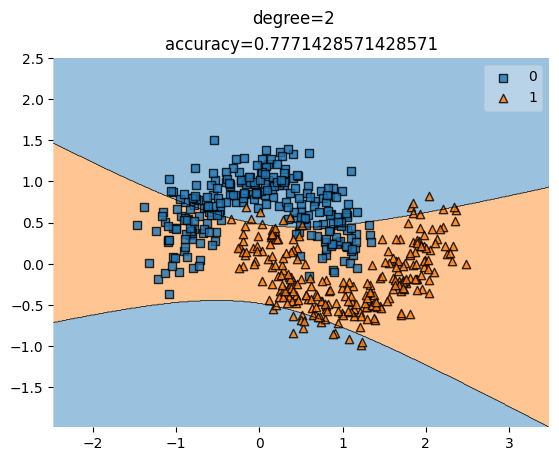

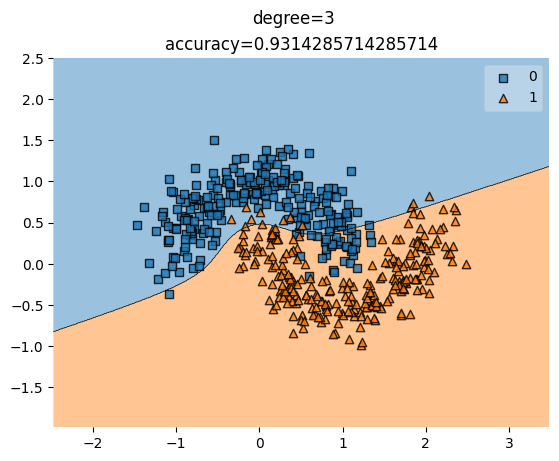

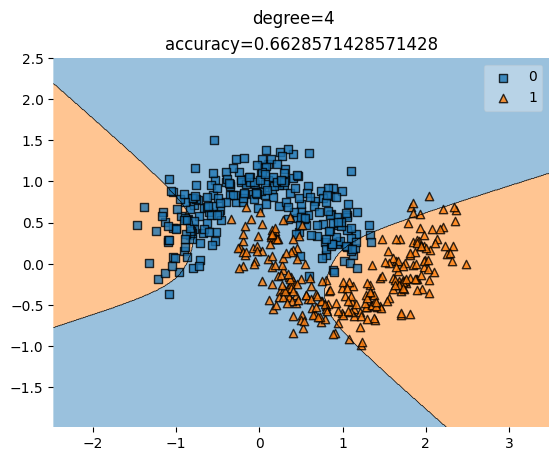

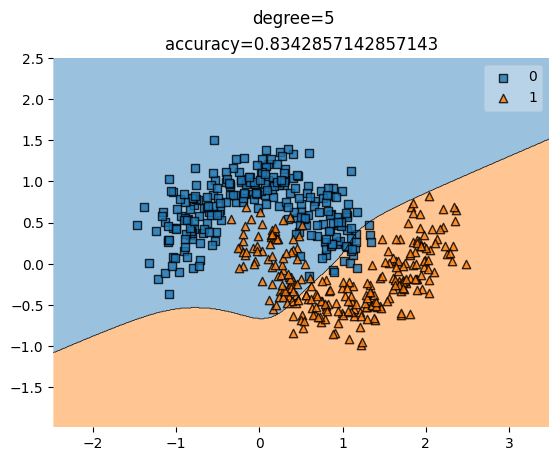

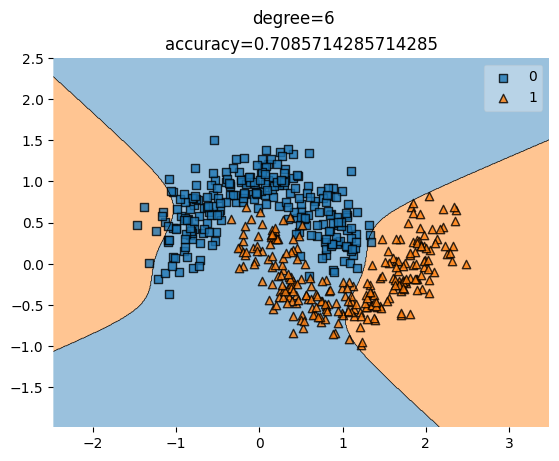

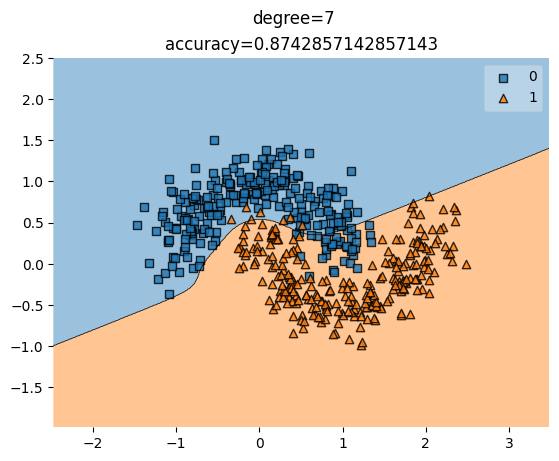

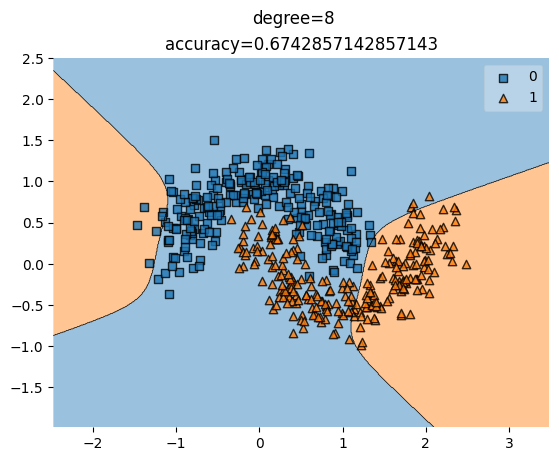

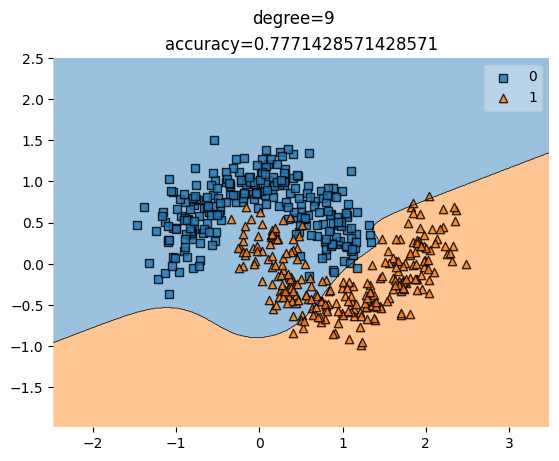

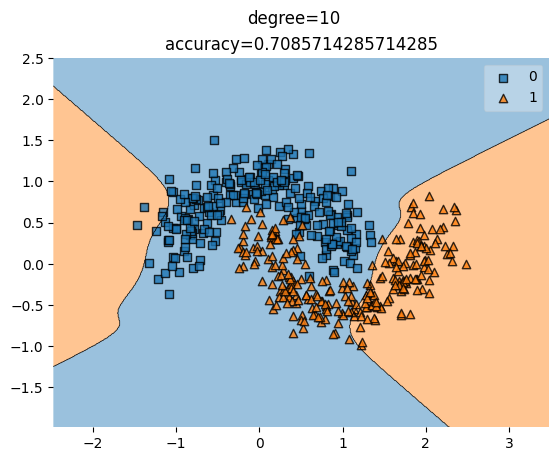

In [271]:
show_svm_poly_decisions(odds_only=False)

Very bad, actually. The best plots come from degrees 1 and 3 (as expected). The even degrees leave no hope

Maybe, it's the regularization to blame?

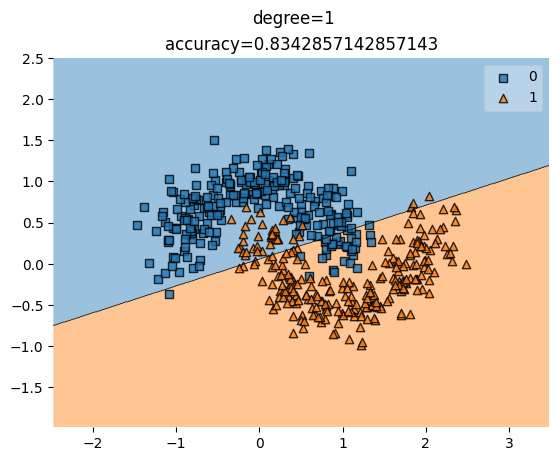

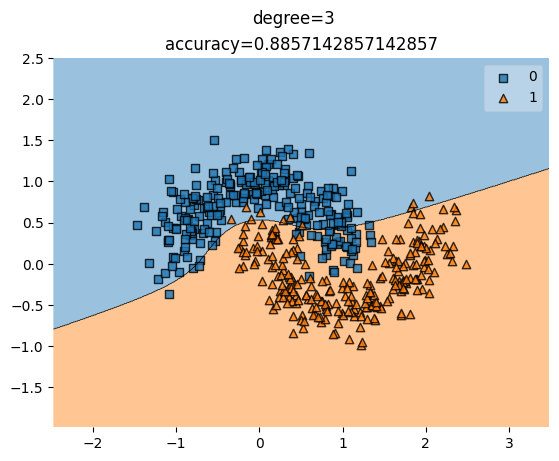

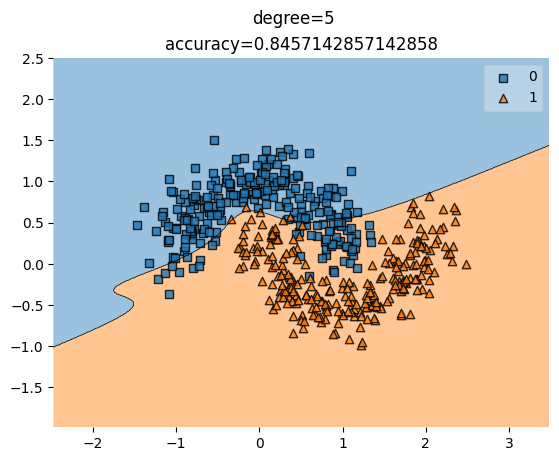

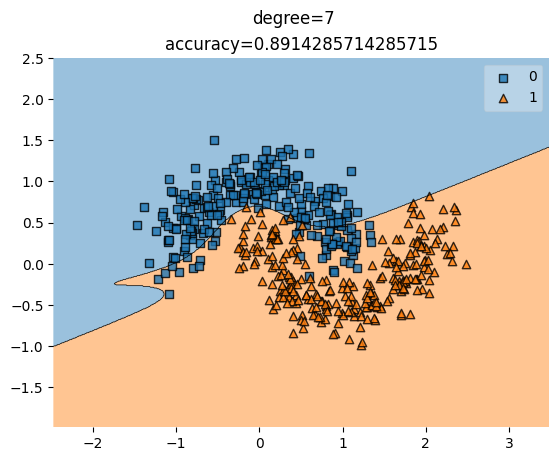

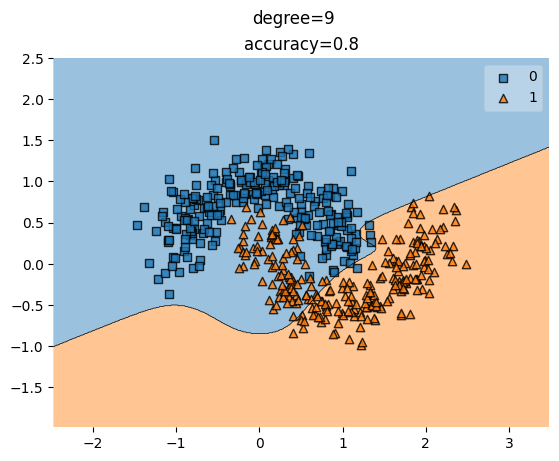

In [272]:
show_svm_poly_decisions(C=10)

Better, but not satisfactory. For $deg>3$ overfitting is visible

### radial basis function

In [293]:
def mk_svm_rbf(γ='scale'):
    return SVC(kernel="rbf", gamma=γ)

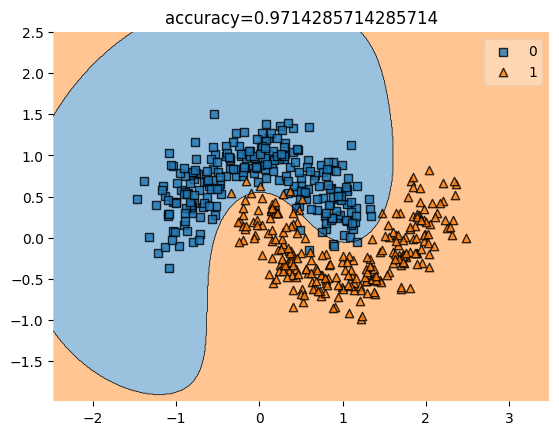

In [273]:
show_decisions_moons(mk_svm_rbf('scale'))

#### other γ's

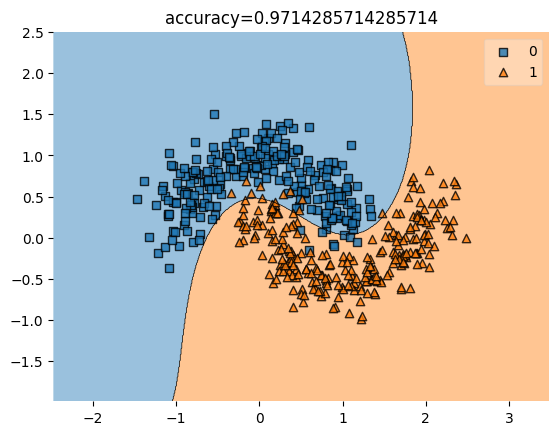

In [274]:
show_decisions_moons(mk_svm_rbf('auto'))

According to documentation, $\gamma=scale$ means $\gamma = 1/(n_{feat} \cdot \sigma_X)$, and $\gamma = auto$ means just $\gamma = 1/n_{feat}$. Let's see what $\sigma_X$ is 

In [134]:
moons_train.var()

0.5646625690895786

Thus, $scale > auto$, in our case. And indeed, as examples below show, the greater $\gamma$ is, the tighter will be the area that encloses the 1s

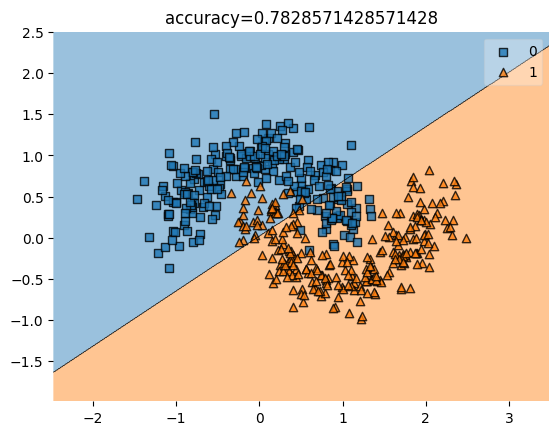

In [275]:
show_decisions_moons(mk_svm_rbf(0.01))

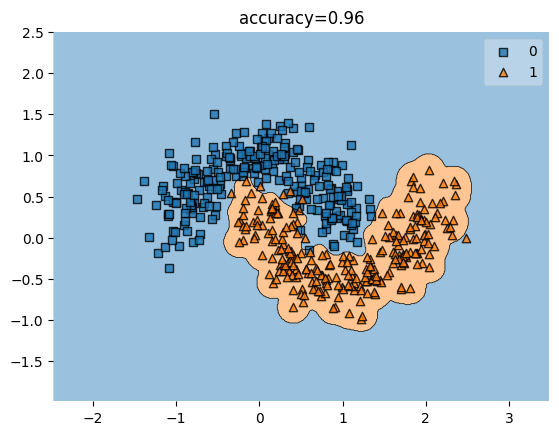

In [276]:
show_decisions_moons(mk_svm_rbf(100))

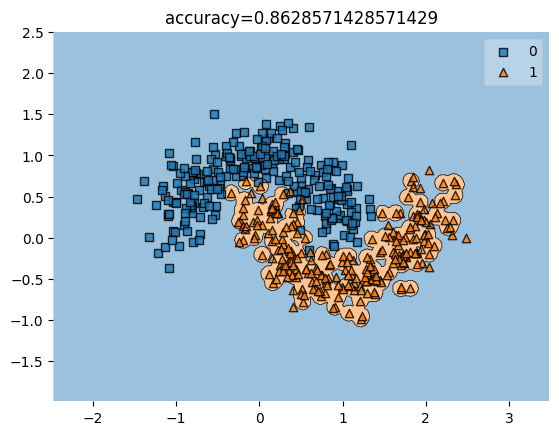

In [277]:
show_decisions_moons(mk_svm_rbf(500))

The last one is just indecently overfitted. Thus, accuracy is dropping (since it is computed on test)

### sigmoid

In [278]:
def mk_svm_sigmoid(γ='scale'):
    return SVC(kernel="rbf", gamma=γ)

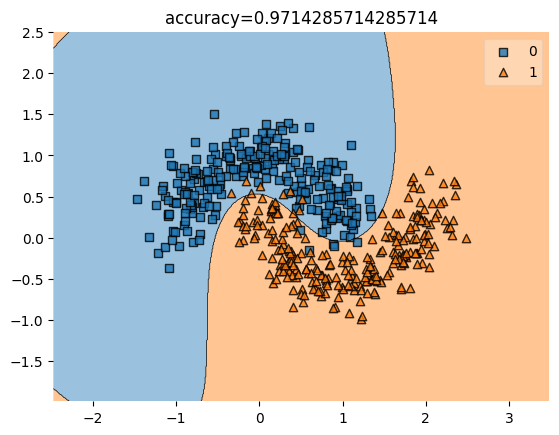

In [279]:
show_decisions_moons(mk_svm_sigmoid())

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [8]:
from sklearn.preprocessing import PolynomialFeatures


### YOUR CODE HERE

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

### Circles

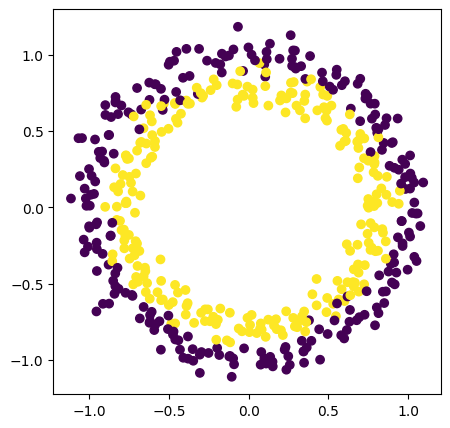

In [213]:
from sklearn.datasets import make_circles


circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
draw_colorful_points(circles_points, circles_labels)

In [214]:
def show_decisions_circles(clf, a=0.35):
    show_decisions(clf, X=circles_points, y=circles_labels, a=a)

The two first ideas that come to mind are quadratic SVM and KNN. Let's try!

In [90]:
knn = KNeighborsClassifier()

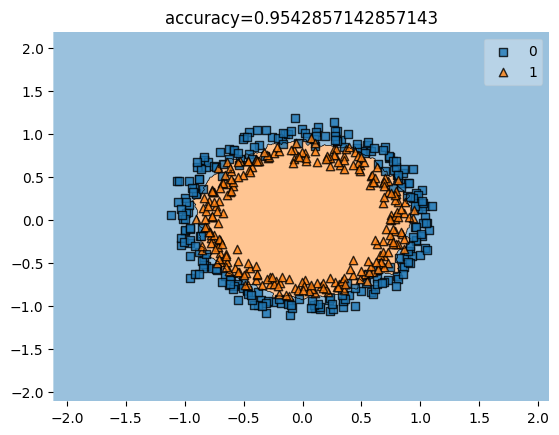

In [280]:
show_decisions_circles(knn)

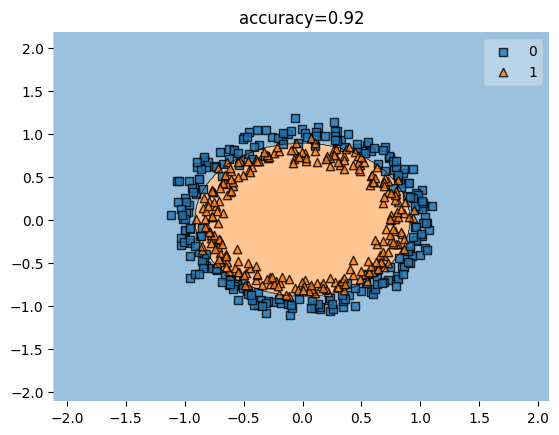

In [281]:
show_decisions_circles(mk_svm_poly(2))

The results are very similar (and both fit data very good), but SVM is, as expected, much-much faster.

In fact, a linear SVM can work, too! All we need is polar coordinates

In [201]:
def xy2polar(x, y):
    r2 = (x * x + y * y)
    θ = np.arctan2(y, x)
    return r2, θ

def data2polar(X):
    r2, θ = xy2polar(X[:, 0], X[:, 1])
    return np.array([r2, θ]).T

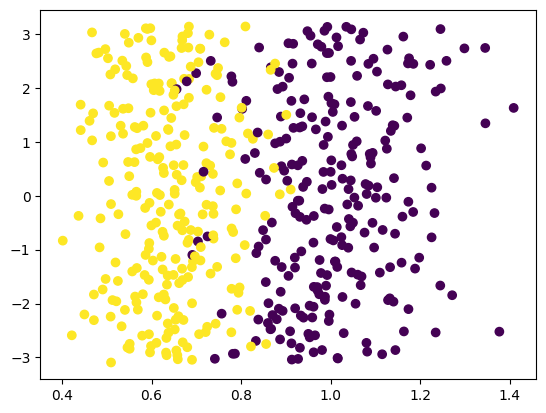

In [220]:
circles_points_polar = data2polar(circles_points)
draw_colorful_points(circles_points_polar, circles_labels)

In [203]:
def show_decisions_circles_polar(clf, a=0.35):
    show_decisions(clf, X=circles_points_polar, y=circles_labels, a=a)

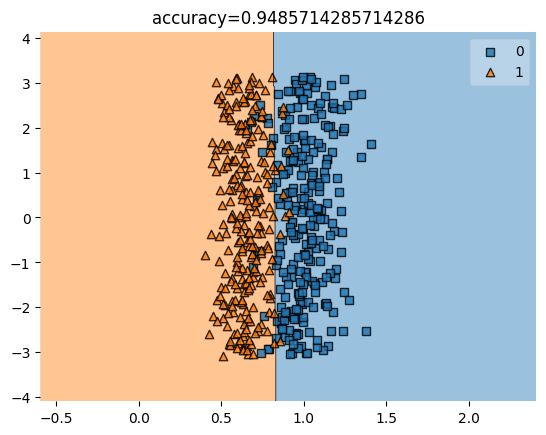

In [282]:
show_decisions_circles_polar(mk_svm_poly(1))

We can try changing the power of radius to make the separation more clear. I tried it on my own and found nothing worth noting. However, if I were optimizing metrics, not just the visual goodness of separation, the power of radius would've been a reasonable hyperparameter to wiggle.


In reality, I do not even need $\theta$'s:

In [216]:
def show_decisions_circles_radius(clf, a=0.35):
    n_samples, n_features = circles_points_polar.shape
    # random instead of zeros, to have a proper cloud, not a line
    X = np.array([circles_points_polar[:, 0], np.random.uniform(low=-1, high=1, size=n_samples)]).T
    show_decisions(clf, X=X, y=circles_labels, a=a)

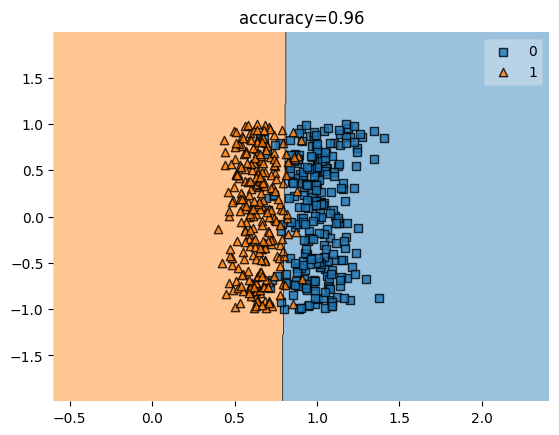

In [283]:
show_decisions_circles_radius(mk_svm_poly(1))

Accuracy with random second feature exceeds accuracy for polar data :)))

### Yin and Yang ☯ ︎

And even more:

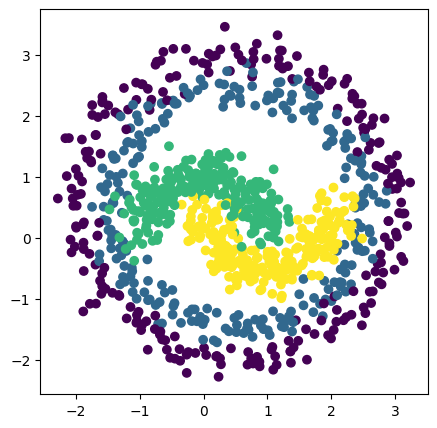

In [229]:
yypoints = np.vstack((circles_points * 2.5 + 0.5, moons_points))
yylabels = np.hstack((circles_labels, moons_labels + 2))  # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
draw_colorful_points(yypoints, yylabels)

In [291]:
def show_decisions_yy(clf, a=0.35):
    show_decisions(clf, X=yypoints, y=yylabels, a=a)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

#### Linear SVM (and Logistic Regression)

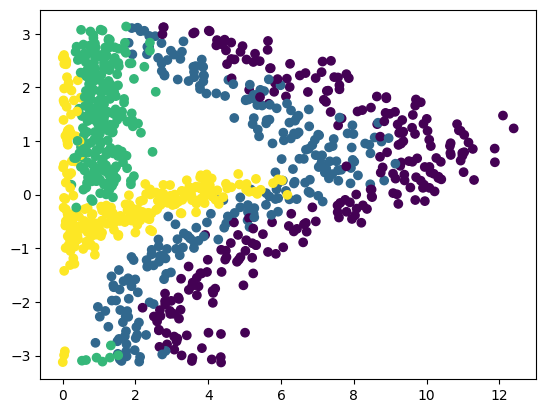

In [234]:
yypolarFAIL = data2polar(yypoints)
draw_colorful_points(yypolarFAIL, yylabels)


Oops! The data is not centred or normalized. Let's fix this

In [232]:
yytrain, yytest, yylabels_train, yylabels_test = train_test_split(yypoints, yylabels, test_size=0.35)
scaler = StandardScaler()
scaler.fit(yytrain)
yyscaled = scaler.transform(yypoints)

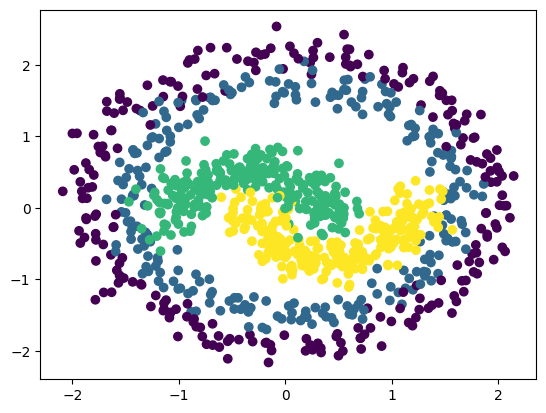

In [233]:
draw_colorful_points(yyscaled, yylabels)

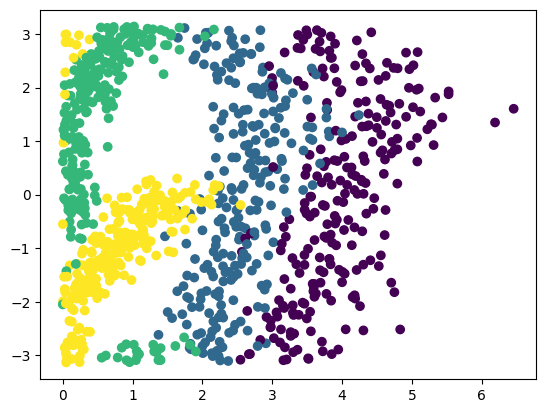

In [235]:
yypolar = data2polar(yyscaled)
draw_colorful_points(yypolar, yylabels)

Still not perfect, but much better.

In [290]:
def show_decisions_yy_polar(clf, a=0.35):
    show_decisions(clf, X=yypolar, y=yylabels, a=a)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


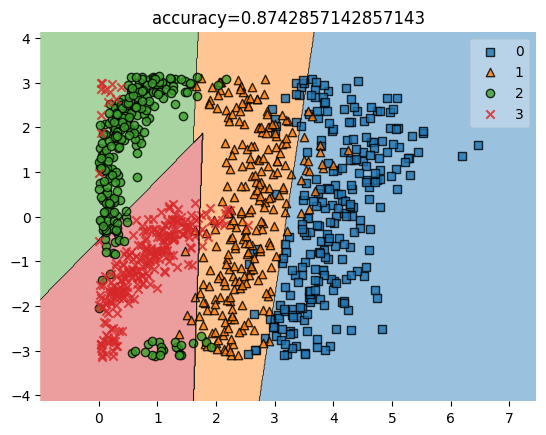

In [284]:
show_decisions_yy_polar(mk_svm_poly(1))

This isn't too bad, actually! Although $yypolar$ looks quite ugly, the separating lines are sort of there --- and SVM found them without trouble!

##### polar variations

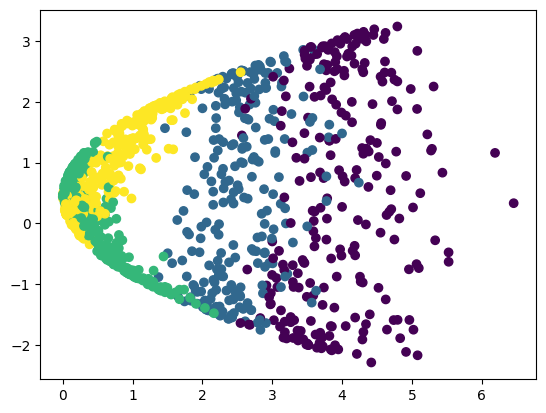

In [247]:
yy_r2x = np.array([yypolar[:, 0], yypoints[:, 0]]).T
draw_colorful_points(yy_r2x, yylabels)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


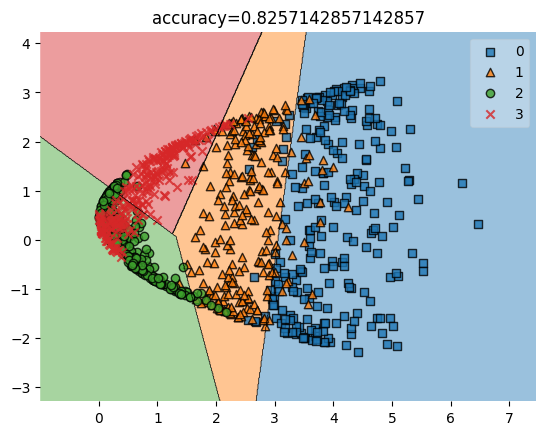

In [285]:
show_decisions(clf=mk_svm_poly(1), X=yy_r2x, y=yylabels)

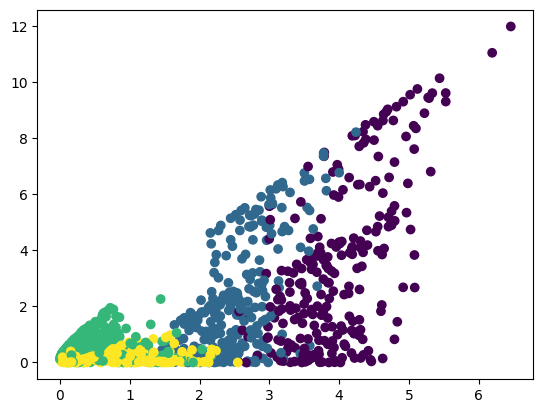

In [259]:
yy_r2y2 = np.array([yypolar[:, 0], yypoints[:, 1]**2]).T
draw_colorful_points(yy_r2y2, yylabels)

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


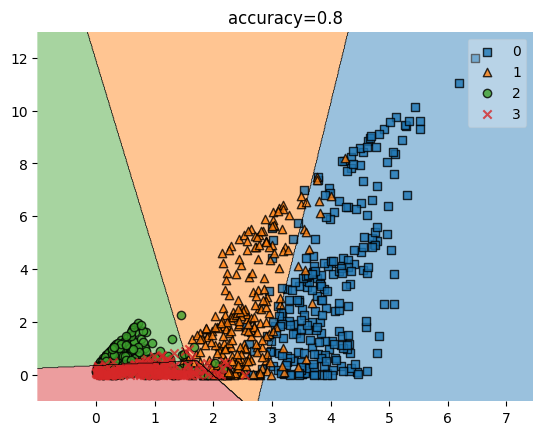

In [288]:
show_decisions(clf=mk_svm_poly(1), X=yy_r2y2, y=yylabels)

##### grid search

Since linear SVM in polar coordinates works fast (a property we should not take for granted, as following examples show) and nice, we can try grid searching a bit to improve further. 

#### Other SVMs

##### sigmoid

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


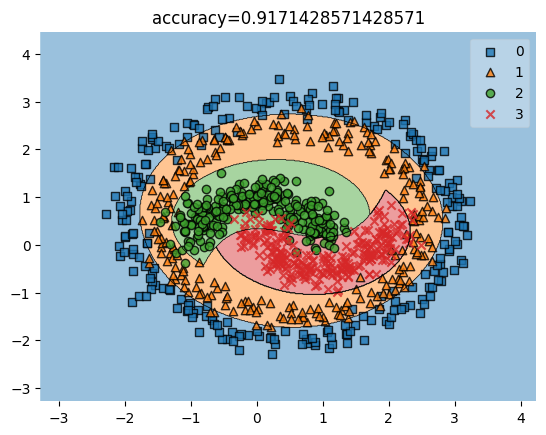

In [298]:
show_decisions_yy(mk_svm_sigmoid())

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


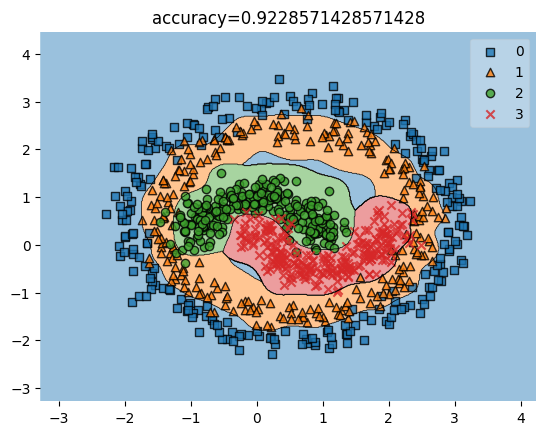

In [299]:
show_decisions_yy(mk_svm_sigmoid(10))

Comments for sigmoid are the same as for rbf, so see below.

##### rbf

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


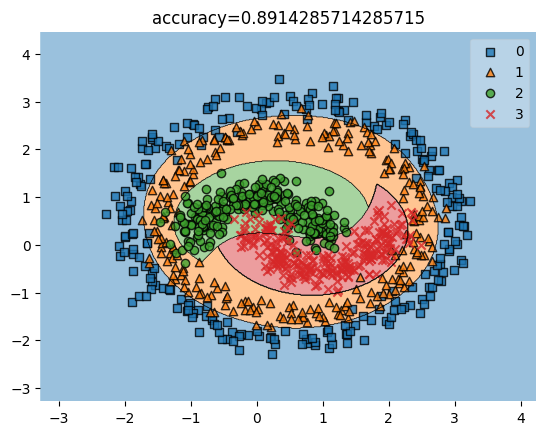

In [294]:
show_decisions_yy(mk_svm_rbf())

This took quite a while, 4-5 times longer than the linear SVM, and gave just a $2\%$ improvement.

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


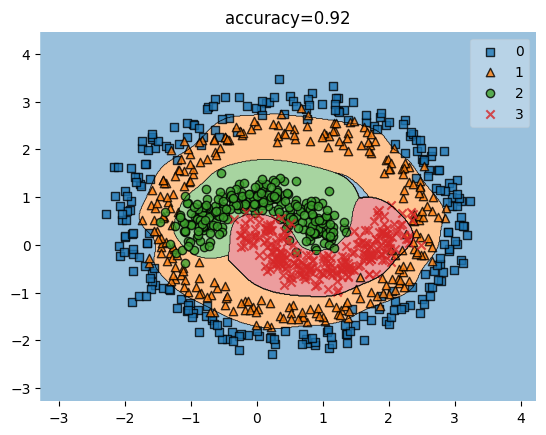

In [295]:
show_decisions_yy(mk_svm_rbf(5))

Very well, a proper choice of $\gamma$ can improve accuracy further, but a simple grid search would take ages, and we would risk overfitting. At this point, I would just use kNN (see below)

#### kNN

c:\Users\Игорь\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


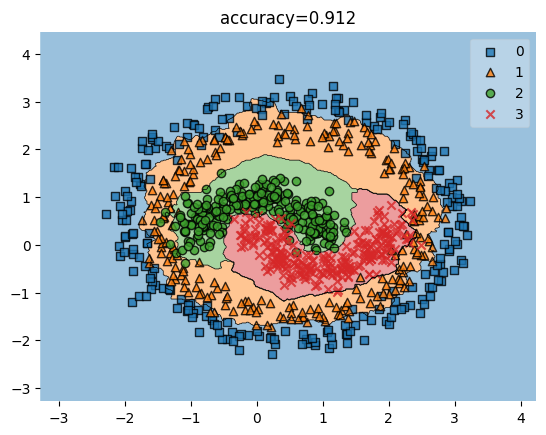

In [297]:
show_decisions_yy(knn, a=0.5)

As always, looks very nice, but works very slow (but faster than rbf and sigmoid!).